## Tiltmeter - Apply Temperature Correction

### Import Libraries

In [1]:
import os
import obspy
import matplotlib.pyplot as plt
import pandas as pd

from numpy import arange, linspace, sqrt, diff, nan, gradient, roll
from pandas import read_csv, DataFrame
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from numpy.ma import filled, isMaskedArray, masked
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from obspy import UTCDateTime
from pathlib import Path

from andbro__querrySeismoData import __querrySeismoData
from andbro__get_seconds import __get_seconds
from andbro__readYaml import __readYaml
from andbro__get_timeaxis import __get_timeaxis

### Define Functions

In [2]:
def __makeplot_simple(pt, bt, config):

    
    fig, axes = plt.subplots(3,2, figsize=(15,5), sharex=True)
    
    for i in range(3):
        
        axes[i,0].plot(pt[i].times()/60, pt[i].data)
        axes[i,1].plot(bt[i].times()/60, bt[i].data)
      
        axes[i,0].grid()
        axes[i,1].grid()
    
    axes[0,0].set_title("Plattform Tiltmeter")
    axes[0,1].set_title("Borehole Tiltmeter")
    
    axes[2,0].set_xlabel("Time (min)")
    axes[2,1].set_xlabel("Time (min)")
    
    axes[0,0].set_ylabel("$\Omega$ (rad)")
    axes[1,0].set_ylabel("$\Omega$ (rad)")
    axes[2,0].set_ylabel("Temp (°C)")
    
    axes[0,1].set_ylabel("$\Omega$ (rad)")
    axes[1,1].set_ylabel("$\Omega$ (rad)")
    axes[2,1].set_ylabel("Temp (°C)")
    
    return fig 

In [3]:
def __smooth(y, box_pts):
    
    from numpy import convolve, ones
    
    box = ones(box_pts)/box_pts
    y_smooth = convolve(y, box, mode='same')
    
    return y_smooth

In [4]:
def __makeplot(pt, bt, config):

    bt_times, bt_ticks, bt_ticklabels, bt_text = __get_timeaxis(
                                                        utcdatetime=bt[0].times(type="utcdatetime"),
                                                        unit='date',
                                                        unitmode='relative',
                                                        dateformat='ddmmyy',
                                                      )    

    pt_times, pt_ticks, pt_ticklabels, pt_text = __get_timeaxis(
                                                        utcdatetime=pt[0].times(type="utcdatetime"),
                                                        unit='date',
                                                        unitmode='relative',
                                                        dateformat='ddmmyy',
                                                      )       
    
    fig, axes = plt.subplots(3,2, figsize=(15,5), sharex=True)
    
    for i in range(3):
        
#         axes[i,0].plot(pt[i].times()/60, pt[i].data)
#         axes[i,1].plot(bt[i].times()/60, bt[i].data)
        axes[i,0].plot(pt_times, pt[i].data)
        axes[i,1].plot(bt_times, bt[i].data)
      
        axes[i,0].grid()
        axes[i,1].grid()
    
    axes[0,0].set_title("Plattform Tiltmeter")
    axes[0,1].set_title("Borehole Tiltmeter")
    
    axes[2,0].set_xlabel(bt_text)
    axes[2,1].set_xlabel(pt_text)
    
    axes[0,0].set_ylabel("$\Omega$ (rad)")
    axes[1,0].set_ylabel("$\Omega$ (rad)")
    axes[2,0].set_ylabel("Temp (°C)")
    
    axes[0,1].set_ylabel("$\Omega$ (rad)")
    axes[1,1].set_ylabel("$\Omega$ (rad)")
    axes[2,1].set_ylabel("Temp (°C)")
    
    return fig 

### Configurations

In [5]:
## configurations
config={}

path = "/home/andbro/Desktop/tiltmeter/"
# path2 = '/home/andbro/Desktop/tiltmeter/WETTER/*ex'

config['tend'] = UTCDateTime.now() 
config['tend'] = UTCDateTime("2021-11-24 00:00") 
config['tbeg'] = config['tend'] - 5*86400

config['tbeg'] = UTCDateTime("2021-08-21 00:00") 
config['tend'] = UTCDateTime("2021-08-31 00:00") 

config['save'] = True

config['seed_id'] = ["BW.TROMY..MA*", "BW.DROMY..LA*"]
config['repository'] = 'george'
config['datapath'] =  None
config['name'] = 'tiltmeter'
config['set_filter'] = 'n'


## tiltmeter configurations
try:
    confTilt = __readYaml('/home/brotzer/Documents/ROMY/','tiltmeter.conf')
except:
    confTilt = __readYaml('./','tiltmeter.conf')
confPT = confTilt['PT']
confBT = confTilt['BT']


## gain for Temperature channel of PT was not set correctly prior to 2021-03-03
correct_settings_temp_PT = ("2021-03-05", config['tend'])

### Load Tiltmeter Data

In [6]:
pt, inv0 = __querrySeismoData(    
                            seed_id=config.get("seed_id")[0],
                            starttime=config.get("tbeg"),
                            endtime=config.get("tend"),
                            where=config.get("repository"),
                            path=config.get("datapath"),
                            restitute=False,
                            detail=None,
                            fill_value=-9999, 
                            )

## downsampled with 5Hz -> 1Hz
pt.resample(1)

pt

TypeError: __querrySeismoData() got an unexpected keyword argument 'where'

In [7]:
bt, inv0 = __querrySeismoData(    
                            seed_id=config.get("seed_id")[1],
                            starttime=config.get("tbeg"),
                            endtime=config.get("tend"),
                            where=config.get("repository"),
                            path=config.get("datapath"),
                            restitute=True,
                            detail=None,
                            fill_value=-9999, 
                            )

bt = bt.trim(starttime=config['tbeg'], endtime=config['tend']-300)
bt

TypeError: __querrySeismoData() got an unexpected keyword argument 'where'

### Covert Data

In [8]:
def __conversion(st, confBT, confPT):

    def convertTemp(trace, gain):
        Tvolt = trace.data * gain
        return 10.18 - 11.59*Tvolt + 0.3335*Tvolt**2 - 0.5316*Tvolt**3

    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity
        # print( type(conversion), type(sensitivity), type(trace.data) )

    for tr in st:
        if tr.stats.channel == 'MAT':
            tr.data = convertTemp(tr, confPT['gainTemp'])
        elif tr.stats.channel == 'MAN':
            tr.data = convertTilt(tr, confPT['convPTN'], confPT['gainTilt'])
        elif tr.stats.channel == 'MAE':
            tr.data = convertTilt(tr, confPT['convPTE'], confPT['gainTilt'])

        elif tr.stats.channel == 'LAT':
            tr.data = convertTemp(tr, confBT['gainTemp'])
        elif tr.stats.channel == 'LAN':
            tr.data = convertTilt(tr, confBT['convBTN'], confBT['gainTilt'])
        elif tr.stats.channel == 'LAE':
            tr.data = convertTilt(tr, confBT['convBTE'], confBT['gainTilt'])

    print("  -> converted data")
    return st

In [9]:
pt = __conversion(pt, confBT, confPT)

bt = __conversion(bt, confBT, confPT)

  -> converted data
  -> converted data


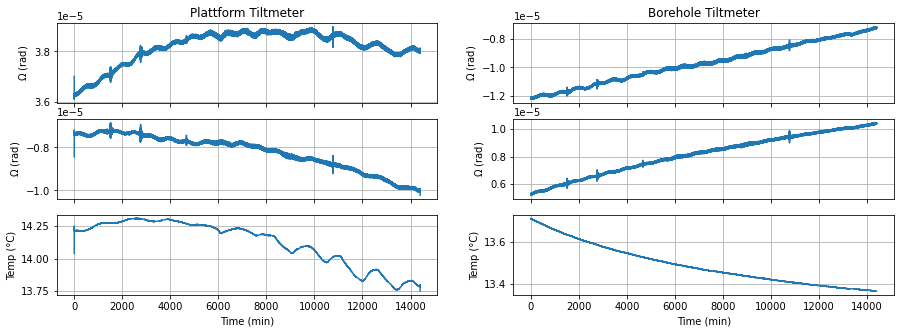

In [10]:
fig = __makeplot_simple(pt, bt, config);

In [11]:
# config['resampling_frequency'] = 0.1

# pt.resample(config['resampling_frequency'])
# bt.resample(config['resampling_frequency'])

# fig = __makeplot(pt, bt, config);

### Correction for temperature Gradient!

#### Polynomial

In [12]:
def __correct_polynomial_trend(st, coefficients):
    
    import numpy.polynomial.polynomial as poly
    from numpy import gradient 
    
    ## calculate derivative of temperature
    delta_temperature = gradient(st[2].data, 2)
    
    ## smoothing derivative
    smoothing = 200
    delta_temperature = __smooth(delta_temperature, smoothing)
    
    ## correct with polynomial    
    st[0].data -= poly.polyval(delta_temperature, coefficients['comp1'])
    st[1].data -= poly.polyval(delta_temperature, coefficients['comp2'])

#     st[0].data +=  coefficients['comp1'][-1]
#     st[1].data +=  coefficients['comp2'][-1]
        
    return st

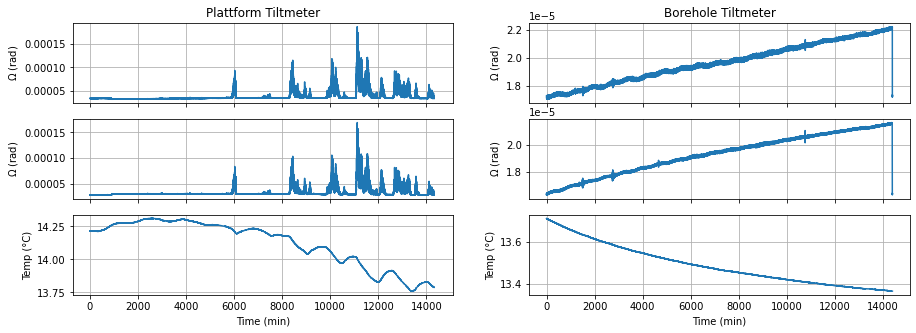

In [25]:
bt_corr = bt.copy()
pt_corr = pt.copy()


## apply crosscorrelation lag
pt_cc_max = [(-53833, 1.0), (-53955, 1.0)]
bt_cc_max = [(117, -1.0), (484, -1.0)]

bt_corr[0].data = roll(bt_corr[0].data, -bt_cc_max[0][0])
bt_corr[1].data = roll(bt_corr[1].data, -bt_cc_max[1][0])

pt_corr[0].data = roll(pt_corr[0].data, -pt_cc_max[0][0])
pt_corr[1].data = roll(pt_corr[1].data, -pt_cc_max[1][0])


## define coefficients
coefficients_bt = {"comp1": [ -2.94065590e-05, -1.78651669e-01, -8.79259917e+03, 1.61743358e+09, 1.56183647e+14],
                   "comp2": [ -1.11617644e-05, -5.68286549e-02, -6.48748167e+03, 6.64077257e+08, 1.01677110e+14]}

coefficients_pt = {"comp1": [  4.38611555e-06, -5.59941240e-01, 3.93011900e+05, 1.35507928e+12, -1.03510040e+18],
                   "comp2": [ -3.72714838e-05, -4.81770384e-01, 3.73016926e+05, 1.07893837e+12, -9.99077091e+17]}


## apply correction
bt_corr = __correct_polynomial_trend(bt_corr, coefficients_bt) 

pt_corr = __correct_polynomial_trend(pt_corr, coefficients_pt) 


fig = __makeplot_simple(pt_corr, bt_corr, config);

#### Linear - Derivative of Temperature

Apply linear slopes obtained by ODR with with a cc-shift and for Tilt-TemperatureRATE-cuves. Temperature Rate is smoothed.

In [20]:
def __correct_linear_trend(st, slope):

    from numpy import gradient 
    
    ## calculate derivative of temperature
    delta_temperature = gradient(st[2].data, 2)
    
    ## smoothing derivative
    smoothing = 100
    delta_temperature = __smooth(delta_temperature, smoothing)
    
    plt.plot(delta_temperature)
    
    ## correct with linear regression
    st[0].data = st[0].data - slope['comp1']*delta_temperature
    st[1].data =  st[1].data - slope['comp2']*delta_temperature 
        
    return st    

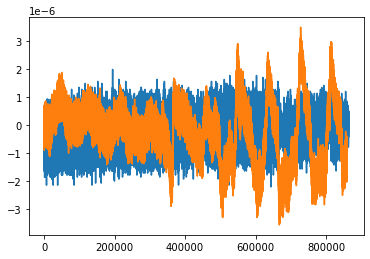

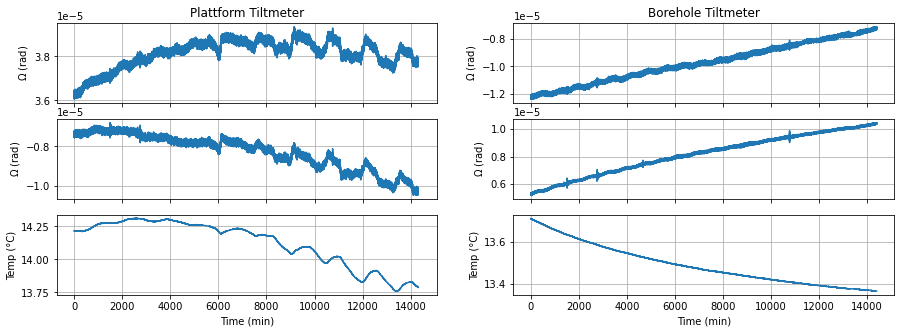

In [28]:
bt_corr = bt.copy()
pt_corr = pt.copy()


## define slopes
bt_slopes = {"comp1": -0.11993096632115328,
             "comp2": -0.034251659309607038}

pt_slopes = {"comp1": -0.24049436637287583,
             "comp2":  -0.21331569800596012}

## apply correction
bt_corr = __correct_linear_trend(bt_corr, bt_slopes) 
pt_corr = __correct_linear_trend(pt_corr, pt_slopes) 


fig = __makeplot_simple(pt_corr, bt_corr, config);

#### Linear - Temperature

Apply linear slopes obtained by ODR with no cc-shift for Tilt-Temperature-cuves

In [16]:
def __correct_linear_trend(st, slope):

    from numpy import gradient 
    
    ## correct with linear regression
    st[0].data = st[0].data - slope['comp1']*st[2].data
    st[1].data = st[1].data - slope['comp2']*st[2].data 
        
    return st    

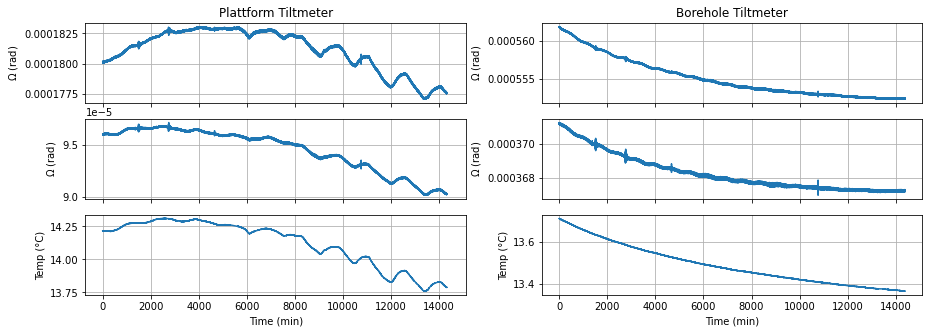

In [19]:
bt_corr = bt.copy()
pt_corr = pt.copy()

bt_slopes = {"comp1": -4.1869024143133607e-05,
             "comp2": -2.6692870421516478e-05}

pt_slopes = {"comp1": -1.0118575808332317e-05,
             "comp2": -7.2721582999409613e-06}


bt_corr = __correct_linear_trend(bt_corr, bt_slopes) 
pt_corr = __correct_linear_trend(pt_corr, pt_slopes) 


fig = __makeplot_simple(pt_corr, bt_corr, config);